# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

<img src='pics/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or other kinds of reconstruction and transformation!

<img src='pics/denoising.png' width=60%/>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Compressed-Representation" data-toc-modified-id="Compressed-Representation-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Compressed Representation</a></span></li></ul></li><li><span><a href="#Import-libraries,-load-and-transform-data" data-toc-modified-id="Import-libraries,-load-and-transform-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load and transform data</a></span><ul class="toc-item"><li><span><a href="#Visualize-the-Data" data-toc-modified-id="Visualize-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Visualize the Data</a></span></li></ul></li><li><span><a href="#Linear-Autoencoder" data-toc-modified-id="Linear-Autoencoder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Autoencoder</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Checking-out-the-results" data-toc-modified-id="Checking-out-the-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checking out the results</a></span></li><li><span><a href="#Up-Next" data-toc-modified-id="Up-Next-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Up Next</a></span></li></ul></div>

## Import libraries, load and transform data

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

100%|█████████▉| 9863168/9912422 [00:26<00:00, 400030.86it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 100246.65it/s]           

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



0it [00:00, ?it/s]
100%|█████████▉| 1646592/1648877 [00:10<00:00, 39065.66it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw




0it [00:00, ?it/s]

  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 29245.22it/s]            

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


In [3]:
# Create training and test dataloaders

# Number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

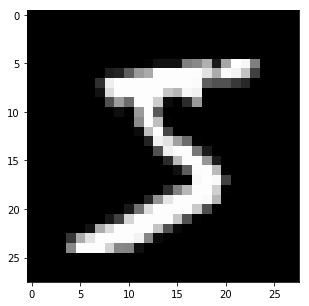

In [5]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray');

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_.

**Important:** Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='pics/simple_autoencoder.png' width=50% />


**Solution design:** 
> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. 
> The encoder and decoder will be made of two linear layers, each.
> The depth dimensions should change as follows: 784 inputs > **encoding_dim** > 784 outputs.
> All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.
> The compressed representation should be a vector with dimension `encoding_dim=32`.

In [23]:
# Define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.fc1 = nn.Linear(784, encoding_dim)
        ## decoder ##
        self.fc2 = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.torch.sigmoid(self.fc2(x))
        
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


---
## Training

As we are not too interested in validation here, we just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [24]:
# Specify loss function
criterion = nn.MSELoss()

# Specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.681367
Epoch: 2 	Training Loss: 0.357591
Epoch: 3 	Training Loss: 0.320415
Epoch: 4 	Training Loss: 0.313099
Epoch: 5 	Training Loss: 0.309596
Epoch: 6 	Training Loss: 0.307246
Epoch: 7 	Training Loss: 0.305494
Epoch: 8 	Training Loss: 0.304051
Epoch: 9 	Training Loss: 0.302842
Epoch: 10 	Training Loss: 0.301813
Epoch: 11 	Training Loss: 0.300925
Epoch: 12 	Training Loss: 0.300086
Epoch: 13 	Training Loss: 0.299329
Epoch: 14 	Training Loss: 0.298664
Epoch: 15 	Training Loss: 0.298071
Epoch: 16 	Training Loss: 0.297518
Epoch: 17 	Training Loss: 0.297003
Epoch: 18 	Training Loss: 0.296522
Epoch: 19 	Training Loss: 0.296068
Epoch: 20 	Training Loss: 0.295647


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.